# I succumb to the notebook supremacy (and may the devil smite hyperspy)

In [2]:
from pathlib import Path

import compress_pickle as cp
import hyperspy.io as hs_load
import hyperspy.utils.plot as hs_plot
import imageio.v3 as imageio
import matplotlib.pyplot as plt
import orix
import orix.crystal_map
import orix.io
import orix.quaternion
import orix.sampling
import pyxem as pxm
from diffpy.structure import Atom, Lattice, Structure, loadStructure
from diffsims.generators.simulation_generator import SimulationGenerator
from diffsims.simulations import Simulation2D

%matplotlib widget

In [3]:
# NB: Wrong atom positions
# a = 5.430986  # lattice parameter in Å
# atoms = (
#     Atom("Si", (0, 0, 0)),
#     Atom("Si", (0.25, 0, 0.25)),
#     Atom("Si", (0, 0.25, 0.25)),
#     Atom("Si", (0.25, 0.25, 0)),
# )
# lattice = Lattice(a, a, a, 90, 90, 90)
# struct = Structure(atoms, lattice)

# struct = loadStructure("mp-149_Si.cif")
# phase = orix.crystal_map.Phase(name="Si", space_group=227, structure=struct)
phase = orix.crystal_map.Phase.from_cif("mp-149_Si.cif")
phase.space_group = 227

grid = orix.sampling.get_sample_reduced_fundamental(
    resolution=0.5,
    point_group=phase.point_group,
)
simgen = SimulationGenerator(precession_angle=0.0, minimum_intensity=1e-5)

try:
    with open("simulations.pkl", "rb") as sim_f:
        simulations: Simulation2D = cp.load(sim_f, compression="gzip")
except FileNotFoundError:
    print("Running simulations")
    simulations = simgen.calculate_diffraction2d(
        phase=phase,  # Which phase(s) to simulate for
        rotation=grid,  # Which orientations to simulate for.
        reciprocal_radius=1.5,  # Max radius to consider, in reciprocal Ångström.
        with_direct_beam=False,  # Whether to include the direct beam in simulations.
        max_excitation_error=0.01,  # Maximal excitation error s, in reciprocal Ångström, used for rel-rod length.
    )
    with open("simulations.pkl", "wb") as sim_f:
        cp.dump(simulations, sim_f, compression="gzip")

In [9]:
dataset = "Si_4"
data_folder = Path(f"../si_data/{dataset}/tiff")
# TODO: use the cred parser instead
pixelsize = 0.0036496  # (Å^-1) / px
images = hs_load.load(dataset + ".hspy", lazy=True)

img = images.inav[::10]

img: pxm.signals.ElectronDiffraction2D = img
img.set_diffraction_calibration(pixelsize)
pol: pxm.signals.PolarDiffraction2D = img.get_azimuthal_integral2d(npt=112)
res: pxm.signals.OrientationMap = pol.get_orientation(
    simulations, n_best=5 or grid.size, frac_keep=1.0
)

WARNING | Hyperspy | The function you applied does not take into account the difference of units and of scales in-between axes. (hyperspy.signal:5331)


WARNING | Hyperspy | The function you applied does not take into account the difference of units and of scales in-between axes. (hyperspy.signal:5331)


In [8]:
img.plot(cmap="viridis_r", norm="log")
marker: hs_plot.markers.Points = res.to_markers(annotate=True)
img.add_marker(marker)

WARNING | Hyperspy | The function you applied does not take into account the difference of units and of scales in-between axes. (hyperspy.signal:5331)


WARNING | Hyperspy | The function you applied does not take into account the difference of units and of scales in-between axes. (hyperspy.signal:5331)


WARNING | Hyperspy | The function you applied does not take into account the difference of units and of scales in-between axes. (hyperspy.signal:5331)


WARNING | Hyperspy | The function you applied does not take into account the difference of units and of scales in-between axes. (hyperspy.signal:5331)


WARNING | Hyperspy | The function you applied does not take into account the difference of units and of scales in-between axes. (hyperspy.signal:5331)


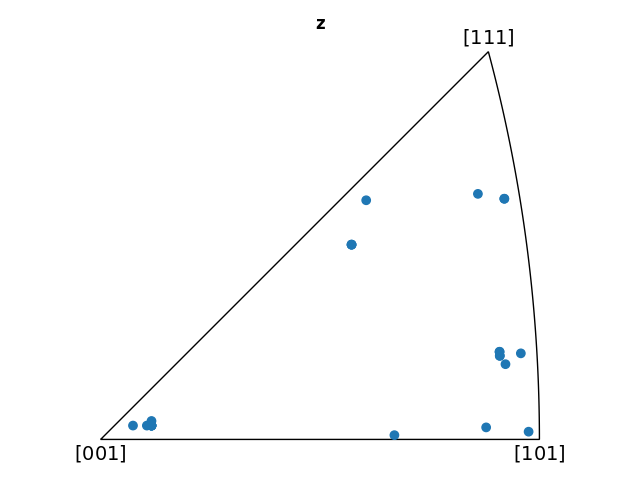

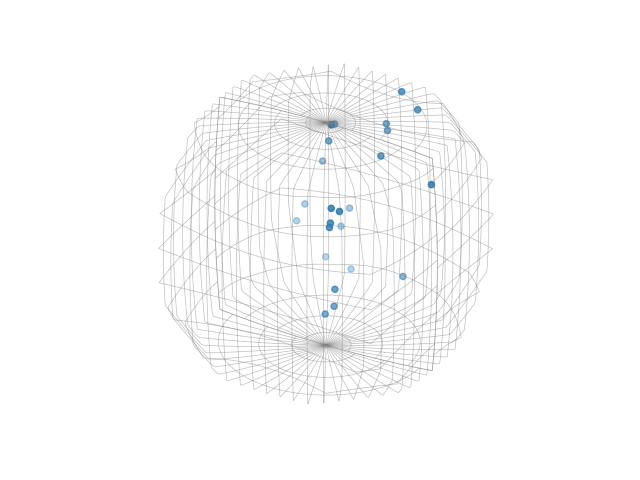

In [10]:
loris = res.to_single_phase_orientations()
loris_best = loris[:, 0]
# loris_best.symmetry = orix.symmetry.Oh
loris_best.scatter("ipf")
loris_best.scatter()


In [5]:
print(loris_best.to_euler(degrees=True))

[[280.           5.69846364 105.21372291]
 [217.          40.01373187  91.7874588 ]
 [ 48.          42.17113243  77.60859663]
 [ 31.          37.28528951 132.00566788]
 [214.          42.11137276  78.16833761]
 [ 47.          47.85103606  59.19659843]
 [282.          33.38325281  52.18399007]
 [ 17.           5.69846364 105.21372291]
 [251.           3.80641947  66.82248815]
 [231.           5.69846364  74.78627709]
 [343.          31.00266767  89.16789764]
 [ 78.          42.17113243  77.60859663]
 [ 19.          33.38325281  52.18399007]
 [ 98.           5.69846364  74.78627709]
 [ 63.           5.84817083 109.93398956]
 [ 82.          33.38325281 127.81600993]
 [104.           5.69846364  74.78627709]
 [332.          42.11137276  78.16833761]
 [259.          42.48415586  79.47154441]
 [ 27.          44.08819209  78.42399573]
 [144.          47.85103606  59.19659843]
 [107.           5.21797328  73.33721897]
 [327.          44.00467624  88.96447729]
 [ 30.          46.04578489  56.94